# **Macro Analysis**

Importing Libraries and Loading the Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("C:\\Users\\ummes\\Downloads\\multivariate+gait+data (1).zip") 

print(df.head())
print(df.columns)

   subject  condition  replication  leg  joint  time     angle
0        1          1            1    1      1     0  4.682881
1        1          1            1    1      1     1  5.073127
2        1          1            1    1      1     2  5.229774
3        1          1            1    1      1     3  5.083273
4        1          1            1    1      1     4  4.652399
Index(['subject', 'condition', 'replication', 'leg', 'joint', 'time', 'angle'], dtype='object')


In [3]:
df = df.sort_values(['subject','condition','replication','leg','joint','time']).reset_index(drop=True)

# Feature Engineering

In [4]:
# Compute delta-time and delta-angle within each sequence
df['vel'] = df.groupby(['subject','condition','replication','leg','joint'])['angle'].diff() / \
            df.groupby(['subject','condition','replication','leg','joint'])['time'].diff()

In [5]:
df['acc'] = df.groupby(['subject','condition','replication','leg','joint'])['vel'].diff() / df.groupby(['subject','condition','replication','leg','joint'])['time'].diff()

In [6]:
df['vel'] = df['vel'].interpolate(method='linear', limit_direction='both')

In [7]:
df['acc'] = df['acc'].interpolate(method='linear', limit_direction='both')

In [8]:
df.isna().sum()  #checking for null values

subject        0
condition      0
replication    0
leg            0
joint          0
time           0
angle          0
vel            0
acc            0
dtype: int64

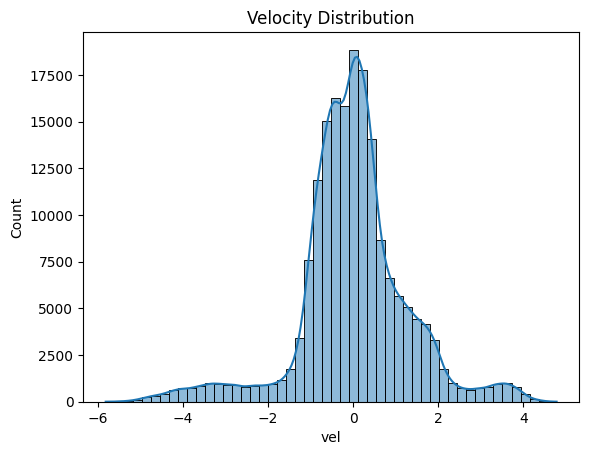

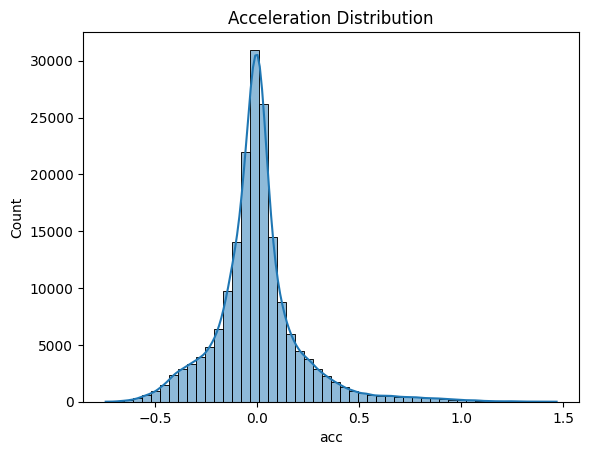

                count       mean        std        min        25%        50%  \
subject      181800.0   5.500000   2.872289   1.000000   3.000000   5.500000   
condition    181800.0   2.000000   0.816499   1.000000   1.000000   2.000000   
replication  181800.0   5.500000   2.872289   1.000000   3.000000   5.500000   
leg          181800.0   1.500000   0.500001   1.000000   1.000000   1.500000   
joint        181800.0   2.000000   0.816499   1.000000   1.000000   2.000000   
time         181800.0  50.000000  29.154840   0.000000  25.000000  50.000000   
angle        181800.0  12.149321  16.025823 -27.004634   1.794457   9.466976   
vel          181800.0  -0.000616   1.294797  -5.812411  -0.600251  -0.011496   
acc          181800.0   0.000922   0.212953  -0.741962  -0.094828  -0.008665   

                   75%         max  
subject       8.000000   10.000000  
condition     3.000000    3.000000  
replication   8.000000   10.000000  
leg           2.000000    2.000000  
joint         

In [9]:
sns.histplot(df['vel'], bins=50, kde=True)
plt.title("Velocity Distribution")
plt.show()

sns.histplot(df['acc'], bins=50, kde=True)
plt.title("Acceleration Distribution")
plt.show()

print(df.describe().T)

In [10]:
df.to_csv("micro_gait_data.csv", index=False)
print("Saved enriched micro dataset with velocity and acceleration.")

Saved enriched micro dataset with velocity and acceleration.


Loading Processed Micro Dataset

In [11]:
df_micro = pd.read_csv("micro_gait_data.csv")

print(df_micro.head())
print(df_micro.shape)

   subject  condition  replication  leg  joint  time     angle       vel  \
0        1          1            1    1      1     0  4.682881  0.390246   
1        1          1            1    1      1     1  5.073127  0.390246   
2        1          1            1    1      1     2  5.229774  0.156647   
3        1          1            1    1      1     3  5.083273 -0.146502   
4        1          1            1    1      1     4  4.652399 -0.430874   

        acc  
0 -0.233599  
1 -0.233599  
2 -0.233599  
3 -0.303149  
4 -0.284372  
(181800, 9)


Reshaping for Macro Analysis

In [12]:
# Define aggregation functions
agg_funcs = {
    'angle': ['mean', 'std', 'min', 'max', 'median'], 
    'vel':   ['mean', 'std', 'min', 'max', 'median'],
    'acc':   ['mean', 'std', 'min', 'max', 'median']
}

# Group and aggregate
df_macro = df_micro.groupby(['subject', 'condition', 'replication']).agg(agg_funcs)

# Flatten multi-level column names
df_macro.columns = ['_'.join(col) for col in df_macro.columns]
df_macro = df_macro.reset_index()

print(df_macro.head())
print(df_macro.shape)


   subject  condition  replication  angle_mean  angle_std  angle_min  \
0        1          1            1   11.556532  15.088670 -15.965032   
1        1          1            2   11.737712  15.977920 -17.492003   
2        1          1            3   11.245866  15.614480 -16.231325   
3        1          1            4   11.559372  15.672279 -16.467403   
4        1          1            5   10.845671  15.326024 -16.289473   

   angle_max  angle_median  vel_mean   vel_std   vel_min   vel_max  \
0  62.445295     10.076578  0.005111  1.313081 -4.692793  3.736549   
1  66.191037      9.966763  0.002502  1.343628 -4.588295  3.838199   
2  65.300057      9.633804 -0.002930  1.381403 -4.981104  3.913851   
3  65.802016      9.500972  0.000439  1.391445 -5.020622  3.967097   
4  64.093660      8.749624 -0.002479  1.362299 -4.997249  3.807093   

   vel_median  acc_mean   acc_std   acc_min   acc_max  acc_median  
0   -0.015406  0.000031  0.216960 -0.551270  1.019209   -0.017769  
1   -0.040

In [13]:
# Range (Mobility Span)
df_macro['angle_range'] = df_macro['angle_max'] - df_macro['angle_min']
df_macro['vel_range']   = df_macro['vel_max']   - df_macro['vel_min']
df_macro['acc_range']   = df_macro['acc_max']   - df_macro['acc_min']

# Coefficient of variation
eps = 1e-8  # to avoid divide-by-zero
df_macro['angle_cv'] = df_macro['angle_std'] / (np.abs(df_macro['angle_mean']) + eps)
df_macro['vel_cv']   = df_macro['vel_std']   / (np.abs(df_macro['vel_mean']) + eps)
df_macro['acc_cv']   = df_macro['acc_std']   / (np.abs(df_macro['acc_mean']) + eps)

# Smoothness metric (ratio of velocity to acceleration variability)
df_macro['smoothness'] = df_macro['vel_std'] / (df_macro['acc_std'] + eps)

print("Added derived features:")
print(['angle_range','vel_range','acc_range',
       'angle_cv','vel_cv','acc_cv','smoothness'])

print("\nNew shape:", df_macro.shape)

Added derived features:
['angle_range', 'vel_range', 'acc_range', 'angle_cv', 'vel_cv', 'acc_cv', 'smoothness']

New shape: (300, 25)


# Exploratory Data Analysis (EDA)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
print(df_macro.info())
print(df_macro.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subject       300 non-null    int64  
 1   condition     300 non-null    int64  
 2   replication   300 non-null    int64  
 3   angle_mean    300 non-null    float64
 4   angle_std     300 non-null    float64
 5   angle_min     300 non-null    float64
 6   angle_max     300 non-null    float64
 7   angle_median  300 non-null    float64
 8   vel_mean      300 non-null    float64
 9   vel_std       300 non-null    float64
 10  vel_min       300 non-null    float64
 11  vel_max       300 non-null    float64
 12  vel_median    300 non-null    float64
 13  acc_mean      300 non-null    float64
 14  acc_std       300 non-null    float64
 15  acc_min       300 non-null    float64
 16  acc_max       300 non-null    float64
 17  acc_median    300 non-null    float64
 18  angle_range   300 non-null    

In [16]:
print(df_macro.isna().sum())

subject         0
condition       0
replication     0
angle_mean      0
angle_std       0
angle_min       0
angle_max       0
angle_median    0
vel_mean        0
vel_std         0
vel_min         0
vel_max         0
vel_median      0
acc_mean        0
acc_std         0
acc_min         0
acc_max         0
acc_median      0
angle_range     0
vel_range       0
acc_range       0
angle_cv        0
vel_cv          0
acc_cv          0
smoothness      0
dtype: int64


In [17]:
print(df_macro['condition'].value_counts())

condition
1    100
2    100
3    100
Name: count, dtype: int64


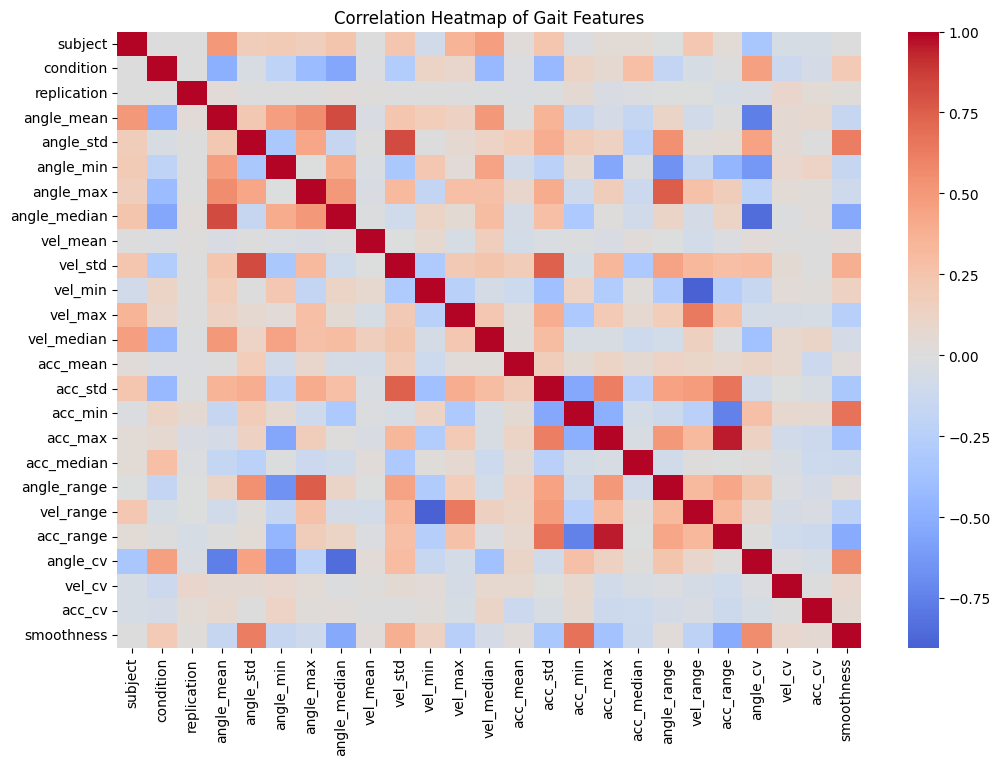

In [18]:
num_cols = df_macro.select_dtypes(include='number').columns
plt.figure(figsize=(12,8))
sns.heatmap(df_macro[num_cols].corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Gait Features")
plt.show()

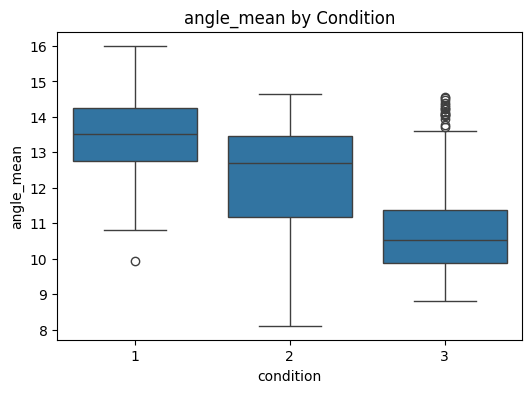

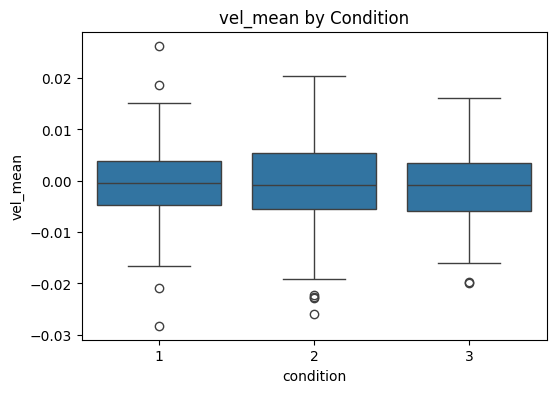

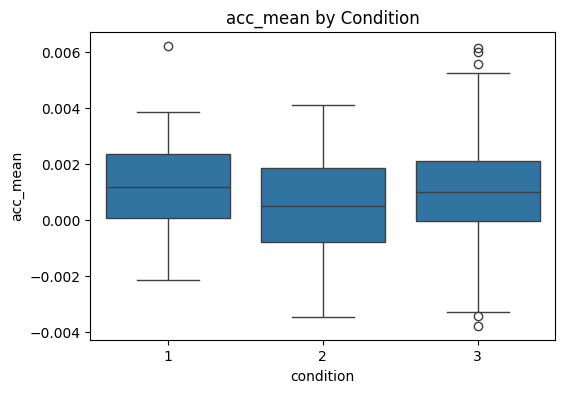

In [19]:
for feature in ['angle_mean', 'vel_mean', 'acc_mean']:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df_macro, x='condition', y=feature)
    plt.title(f"{feature} by Condition")
    plt.show()

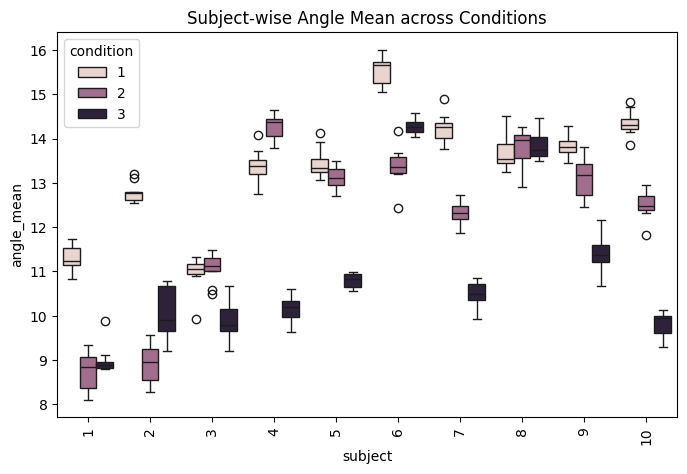

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(x='subject', y='angle_mean', hue='condition', data=df_macro)
plt.title("Subject-wise Angle Mean across Conditions")
plt.xticks(rotation=90)
plt.show()

# Preprocessing

In [95]:
from sklearn.preprocessing import StandardScaler

In [22]:
df = df_macro.copy()

In [56]:
num_cols = [col for col in df_macro.columns if any(f in col for f in ['angle', 'vel', 'acc'])]
num_cols.append('smoothness')
num_cols

['angle_mean',
 'angle_std',
 'angle_min',
 'angle_max',
 'angle_median',
 'vel_mean',
 'vel_std',
 'vel_min',
 'vel_max',
 'vel_median',
 'acc_mean',
 'acc_std',
 'acc_min',
 'acc_max',
 'acc_median',
 'angle_range',
 'vel_range',
 'acc_range',
 'angle_cv',
 'vel_cv',
 'acc_cv',
 'smoothness']

In [57]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [58]:
X = df.drop(columns=['condition', 'subject', 'replication'])
y = df['condition']

# Anomaly Detection

In [59]:
X_healthy = X[y == 1]
X_test = X[(y == 2) | (y==3) ]

In [60]:
print("All features:", X.shape)
print("Healthy subset:", X_healthy.shape)
print("Anomalous subset:", X_test.shape)
print("Sample features:\n", X.head())

All features: (300, 22)
Healthy subset: (100, 22)
Anomalous subset: (200, 22)
Sample features:
    angle_mean  angle_std  angle_min  angle_max  angle_median  vel_mean  \
0   -0.309428  -0.374495  -0.433020  -1.024857      0.279395  0.722803   
1   -0.214854   0.088593  -0.807227  -0.228145      0.227796  0.393544   
2   -0.471591  -0.100673  -0.498279  -0.417655      0.071347 -0.292112   
3   -0.307945  -0.070573  -0.556134  -0.310889      0.008932  0.133112   
4   -0.680487  -0.250890  -0.512529  -0.674253     -0.344107 -0.235123   

    vel_std   vel_min   vel_max  vel_median  ...   acc_min   acc_max  \
0  0.179879 -0.299932 -0.695499   -0.236964  ...  0.150662 -0.105442   
1  0.405947 -0.083735 -0.320673   -0.784019  ...  0.059953 -0.186700   
2  0.685498 -0.896419 -0.041715   -1.210156  ...  0.026809  0.187983   
3  0.759816 -0.978178  0.154626   -1.089345  ... -0.657870 -0.456434   
4  0.544117 -0.929822 -0.435374   -0.968201  ...  0.175408  0.091655   

   acc_median  angle_range

In [61]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [62]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_healthy)    # fit only on healthy data
X_test_scaled = scaler.transform(X_test)      # transform braced data

**USING ISOLATION FOREST**

In [63]:
iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # roughly % of anomalies expected
    random_state=42
)
iso.fit(X_scaled)

,n_estimators,200
,max_samples,'auto'
,contamination,0.05
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [64]:
# Scores for both healthy and test data
healthy_scores = iso.decision_function(X_scaled)
test_scores = iso.decision_function(X_test_scaled)

# Predictions (-1 = anomaly, 1 = normal)
healthy_preds = iso.predict(X_scaled)
test_preds = iso.predict(X_test_scaled)

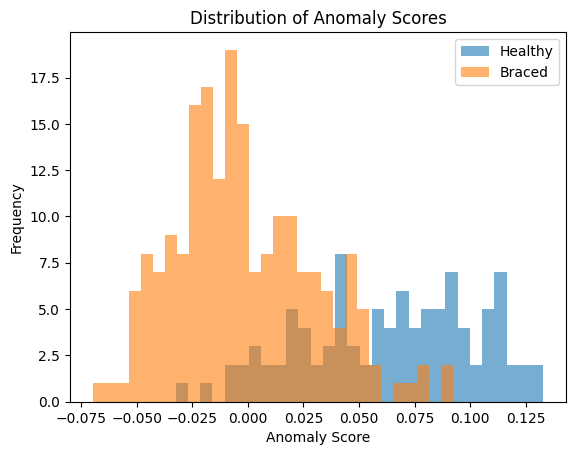

In [65]:
import matplotlib.pyplot as plt

plt.hist(healthy_scores, bins=30, alpha=0.6, label='Healthy')
plt.hist(test_scores, bins=30, alpha=0.6, label='Braced')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.show()

In [66]:
def gait_health_score(score):
    # Normalize anomaly score to [0, 100]
    return 100 * (score - np.min(score)) / (np.max(score) - np.min(score))

# Compute for braced test data
health_scores = gait_health_score(test_scores)

print("Average gait health score (braced):", np.mean(health_scores))

Average gait health score (braced): 42.153683839054366


In [67]:
n_anomalies = np.sum(test_preds == -1)
print(f"Detected anomalies among braced samples: {n_anomalies}/{len(test_preds)}")

Detected anomalies among braced samples: 118/200


**USING ONE CLASS SVM**

In [68]:
from sklearn.svm import OneClassSVM
svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
svm.fit(X_scaled)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,nu,0.05
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [69]:
healthy_scores_svm = svm.decision_function(X_scaled)
test_scores_svm = svm.decision_function(X_test_scaled)

healthy_preds_svm = svm.predict(X_scaled)
test_preds_svm = svm.predict(X_test_scaled)

In [70]:
def normalize_score(scores):
    return 100 * (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

H_IF_norm  = normalize_score(healthy_scores)
B_IF_norm  = normalize_score(test_scores)

H_SVM_norm = normalize_score(healthy_scores_svm)
B_SVM_norm = normalize_score(test_scores_svm)

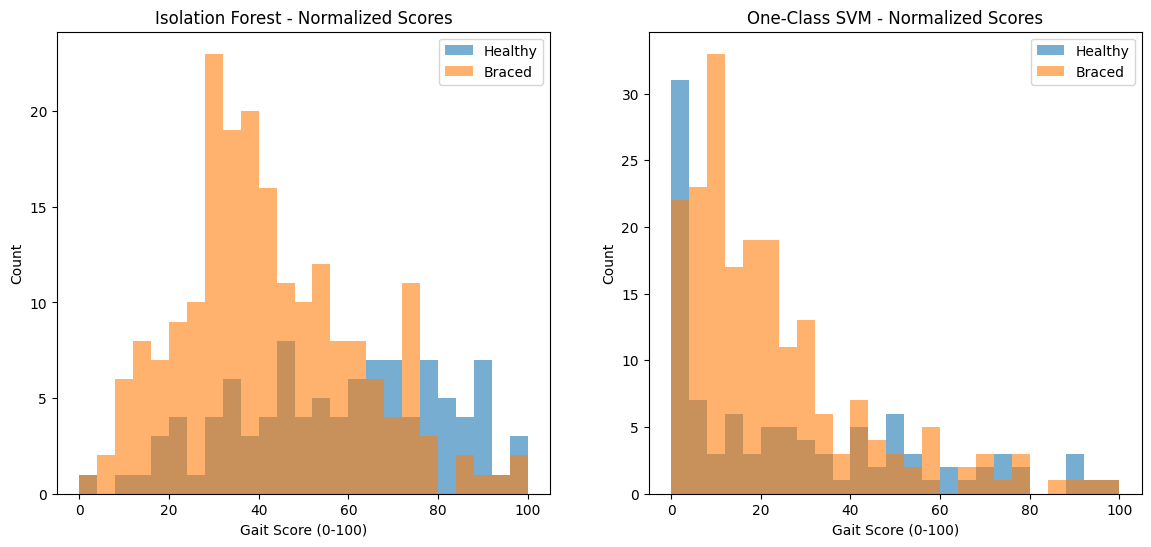

In [71]:
plt.figure(figsize=(14,6))

# Isolation Forest
plt.subplot(1,2,1)
plt.hist(H_IF_norm, bins=25, alpha=0.6, label='Healthy')
plt.hist(B_IF_norm, bins=25, alpha=0.6, label='Braced')
plt.title("Isolation Forest - Normalized Scores")
plt.xlabel("Gait Score (0-100)")
plt.ylabel("Count")
plt.legend()

# One-Class SVM
plt.subplot(1,2,2)
plt.hist(H_SVM_norm, bins=25, alpha=0.6, label='Healthy')
plt.hist(B_SVM_norm, bins=25, alpha=0.6, label='Braced')
plt.title("One-Class SVM - Normalized Scores")
plt.xlabel("Gait Score (0-100)")
plt.ylabel("Count")
plt.legend()

In [72]:
print("Isolation Forest anomalies:", np.sum(test_preds == -1))
print("One-Class SVM anomalies:", np.sum(test_preds_svm == -1))

Isolation Forest anomalies: 118
One-Class SVM anomalies: 192


One-Class SVM produced highly compressed anomaly scores, with many healthy cycles assigned identical minimum values.
This indicates that OCSVM formed an overly tight boundary and failed to differentiate normal gait variability.
Isolation Forest produced more stable and interpretable anomaly scores, therefore is preferred.

In [73]:
health_IF = normalize_score(test_scores)
health_SVM = normalize_score(test_scores_svm)

print(f"Mean gait health score (Isolation Forest): {np.mean(health_IF):.2f}")
print(f"Mean gait health score (One-Class SVM): {np.mean(health_SVM):.2f}")

Mean gait health score (Isolation Forest): 42.15
Mean gait health score (One-Class SVM): 22.60


**Principal Component Analysis**

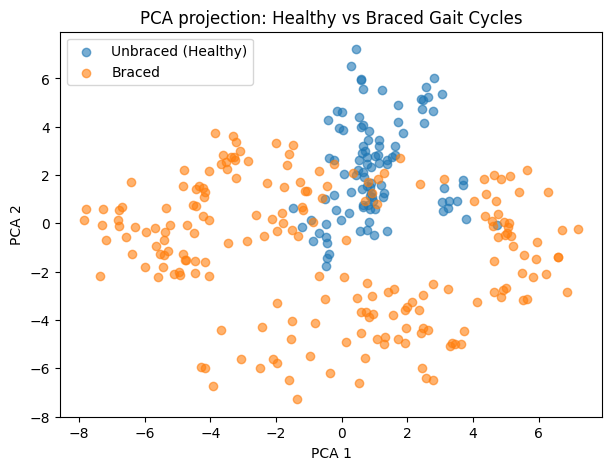

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_all_scaled = np.vstack([X_scaled, X_test_scaled])
labels = np.array([0]*len(X_scaled) + [1]*len(X_test_scaled))

X_pca = pca.fit_transform(X_all_scaled)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[labels==0, 0], X_pca[labels==0, 1], alpha=0.6, label='Unbraced (Healthy)')
plt.scatter(X_pca[labels==1, 0], X_pca[labels==1, 1], alpha=0.6, label='Braced')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA projection: Healthy vs Braced Gait Cycles')
plt.legend()
plt.show()

This overlap explains why anomaly detection struggles—many braced cycles appear “normal,” and some healthy cycles fall near the boundary. Supervised models perform better because they use the full feature space, not just the top two principal components.

C:\Users\ummes\AppData\Local\Temp\ipykernel_20224\3085407787.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([H_IF_norm, B_IF_norm, B_SVM_norm], labels=['Healthy (IF)', 'Braced (IF)', 'Braced (SVM)'])


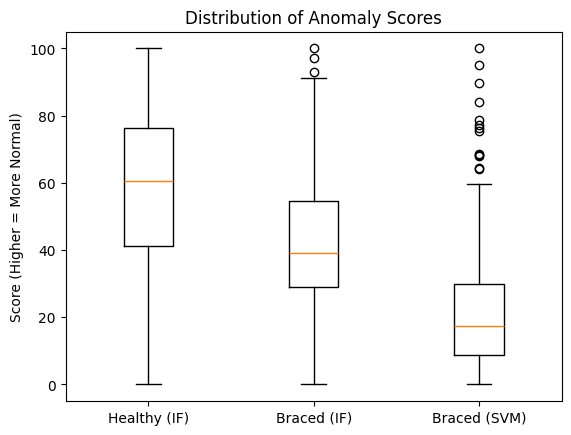

In [75]:
plt.boxplot([H_IF_norm, B_IF_norm, B_SVM_norm], labels=['Healthy (IF)', 'Braced (IF)', 'Braced (SVM)'])
plt.title("Distribution of Anomaly Scores")
plt.ylabel("Score (Higher = More Normal)")
plt.show()

ENSEMBLING GAIT HEALTH INDEX (IF + SVM)

In [76]:
# Normalize both scores between 0–100
def normalize_score(scores):
    return 100 * (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

health_IF = normalize_score(test_scores)
health_SVM = normalize_score(test_scores_svm)

# Ensemble = weighted average (equal weights here)
ensemble_score = (health_IF + health_SVM) / 2

print("Mean ensemble gait health score for braced cycles:", np.mean(ensemble_score))


Mean ensemble gait health score for braced cycles: 32.37845992186167


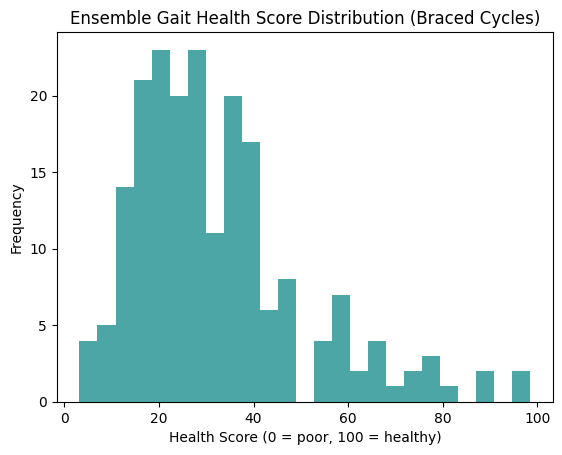

In [77]:
plt.hist(ensemble_score, bins=25, color='teal', alpha=0.7)
plt.title("Ensemble Gait Health Score Distribution (Braced Cycles)")
plt.xlabel("Health Score (0 = poor, 100 = healthy)")
plt.ylabel("Frequency")
plt.show()

# Classification (Predicitng Gait Condition)

In [78]:
# Binary target: 0 = unbraced, 1 = braced
df_macro['condition_binary'] = df_macro['condition'].replace({1: 0, 2: 1, 3: 1})

# Features and target
X = df_macro.drop(columns=['condition', 'condition_binary', 'subject', 'replication'])
y = df_macro['condition_binary']

print("Feature matrix:", X.shape)
print("Target vector:", y.shape)
print(y.value_counts())

Feature matrix: (300, 22)
Target vector: (300,)
condition_binary
1    200
0    100
Name: count, dtype: int64


In [96]:
#subject-wise splitting
from sklearn.model_selection import train_test_split

subjects = df_macro['subject'].unique()

# split subjects, not rows
train_subjects, test_subjects = train_test_split(subjects, test_size=0.3, random_state=42)

train_idx = df_macro['subject'].isin(train_subjects)
test_idx = df_macro['subject'].isin(test_subjects)

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model Training and Evaluation

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Model Performance Report

In [83]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Logistic Regression Results:
Accuracy: 0.9555555555555556
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        30
           1       0.97      0.97      0.97        60

    accuracy                           0.96        90
   macro avg       0.95      0.95      0.95        90
weighted avg       0.96      0.96      0.96        90


Random Forest Results:
Accuracy: 0.8888888888888888
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        30
           1       0.95      0.88      0.91        60

    accuracy                           0.89        90
   macro avg       0.87      0.89      0.88        90
weighted avg       0.90      0.89      0.89        90



In [97]:
# Absolute coefficient values = importance
importance = np.abs(log_reg.coef_[0])

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False, ignore_index=True)

print("Top 10 Important Features (Logistic Regression)")
print(feature_importance.head(10).to_string(index=False))

Top 10 Important Features (Logistic Regression)
     feature  importance
     acc_std    2.404273
     vel_std    2.374744
     vel_max    1.295545
angle_median    0.988053
   acc_range    0.856635
     acc_max    0.790378
    angle_cv    0.717540
     acc_min    0.713387
  vel_median    0.691759
  acc_median    0.599532


In [93]:
import pandas as pd
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
print("Top 10 Important Features (Random Forest)")
print(feat_importances.sort_values(ascending=False).head(10))

Top 10 Important Features (Random Forest)
angle_std       0.168168
vel_std         0.136537
acc_std         0.101390
angle_mean      0.090478
angle_cv        0.079327
angle_median    0.072375
acc_median      0.068150
vel_median      0.050461
smoothness      0.033909
angle_max       0.030433
dtype: float64


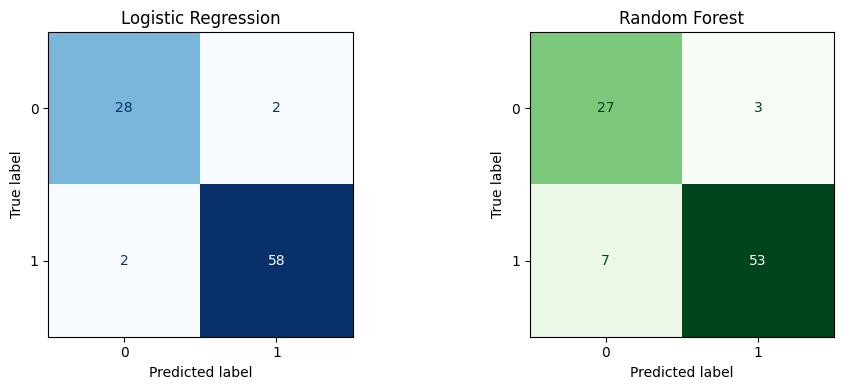

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax[1], cmap="Greens", colorbar=False)
ax[1].set_title("Random Forest")

plt.tight_layout()
plt.show()

# Conclusion

- Visualization and anomaly detection helped identify potential outliers and class separability.
- The modeling stage demonstrated how macro-features can distinguish gait conditions effectively.